In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark
!pip install findspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Initialize a Spark session
spark = SparkSession.builder.appName("CreditScoreMortgageDistribution").getOrCreate()

# Load the cleaned Parquet data
# Check the file path and ensure it's accessible
df = spark.read.parquet("/content/drive/MyDrive/your_path/combined.parquet")

# If the error persists try printing the dataframe to check its contents
# This might reveal more information about potential data issues
df.show()

+-----------------+------------+------------------------+-------+-------------+------------+---------------+----------------------+---------------------+-------------------+---------------+-----------+------------------+----------------+------------------+--------+----------------------------------+-------------------------------------+-------------+---------------------------------+-------------------------------------------+-------------------+-------------------+------------------------------------+---------------------------------------+-------------------------------+------------+-------------+---------------+----------------+--------------+-----+--------------+-----------------------------+-----------------+----------------------------+----------------------------+---------------------+----------------------+-------------------------------+--------------------+-----------------+-------------------------------+-----------------+---------------------------+-------------------------

In [ ]:
# prompt: count the number of rows and column

from pyspark.sql.functions import count

# Count the number of rows
num_rows = df.count()

# Count the number of columns
num_cols = len(df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 673626493
Number of columns: 111


## Q1. Compare the average FICO across the two years.


In [ ]:
loans_df = df

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col

# Create a SparkSession
# Check if a SparkSession already exists. If not, create a new one
spark = SparkSession.builder.appName("Loan Delinquency Analysis").getOrCreate()


loans_df = loans_df.withColumn("FICO_Score", col("Borrower_Credit_Score_at_Origination"))

# Group by Type and calculate average delinquency status, including the FICO score
result = loans_df.groupBy("Type") \
    .agg(
        avg("Current_Loan_Delinquency_Status").alias("Avg_Delinquency_Status"),
        avg("FICO_Score").alias("Avg_FICO_Score")  # Average FICO Score
    ) \
    .orderBy("Type")

# Show the results
result.show()

# To compare type = 0 (2002 data) and type = 1 (2003 data)
comparison = result.filter((result.Type == 0) | (result.Type == 1))
comparison.show()

+----+----------------------+-----------------+
|Type|Avg_Delinquency_Status|   Avg_FICO_Score|
+----+----------------------+-----------------+
|   0|   0.13694464490893002|725.2110360069813|
|   1|   0.12645549489282656|731.9563417137896|
+----+----------------------+-----------------+

+----+----------------------+-----------------+
|Type|Avg_Delinquency_Status|   Avg_FICO_Score|
+----+----------------------+-----------------+
|   0|   0.13694464490893002|725.2110360069813|
|   1|   0.12645549489282656|731.9563417137896|
+----+----------------------+-----------------+



## Q2. The monthly delinquency rates for 30, 60 and 90 days past due and how they vary by loan term


In [ ]:
delinquency_df = df

In [ ]:
from pyspark.sql import functions as F

# Create delinquency buckets based on Current_Loan_Delinquency_Status
df = df.withColumn('delinquency_bucket',
                   F.when(col('Current_Loan_Delinquency_Status') == 0, 'No Delinquency')
                   .when(col('Current_Loan_Delinquency_Status') == 1, '30 Days')
                   .when(col('Current_Loan_Delinquency_Status') == 2, '60 Days')
                   .when(col('Current_Loan_Delinquency_Status') == 3, '90 Days')
                   .otherwise('90+ Days'))

# Group by Monthly Reporting Period, Loan Term, and Delinquency Bucket, and calculate the mean for each bucket
delinquency_rates = df.groupBy('Monthly_Reporting_Period', 'Original_Loan_Term', 'delinquency_bucket')\
                      .agg(F.mean('Current_Loan_Delinquency_Status').alias('avg_delinquency'))

# Display the result
delinquency_rates.show()



+------------------------+------------------+------------------+-----------------+
|Monthly_Reporting_Period|Original_Loan_Term|delinquency_bucket|  avg_delinquency|
+------------------------+------------------+------------------+-----------------+
|                   82009|               180|    No Delinquency|              0.0|
|                   22007|               360|    No Delinquency|              0.0|
|                   32013|               360|    No Delinquency|              0.0|
|                   22018|               360|    No Delinquency|              0.0|
|                   42005|               360|          90+ Days|9.125277983691623|
|                   82008|               360|           90 Days|              3.0|
|                   32003|               355|    No Delinquency|              0.0|
|                   52005|               180|           30 Days|              1.0|
|                  122020|               180|    No Delinquency|              0.0|
|   

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Create separate columns for each delinquency bucket (30 days, 60 days, 90+ days)
df = df.withColumn('30_days', F.when(col('Current_Loan_Delinquency_Status') == 1, 1).otherwise(0)) \
       .withColumn('60_days', F.when(col('Current_Loan_Delinquency_Status') == 2, 1).otherwise(0)) \
       .withColumn('90_days', F.when(col('Current_Loan_Delinquency_Status') >= 3, 1).otherwise(0))

# Group by Monthly Reporting Period and Loan Term, and calculate the mean for each delinquency bucket
delinquency_rates = df.groupBy('Monthly_Reporting_Period', 'Original_Loan_Term')\
                      .agg(F.mean('30_days').alias('30_Days_Avg'),
                           F.mean('60_days').alias('60_Days_Avg'),
                           F.mean('90_days').alias('90+_Days_Avg'))

# Display the result
delinquency_rates.show()


+------------------------+------------------+--------------------+--------------------+--------------------+
|Monthly_Reporting_Period|Original_Loan_Term|         30_Days_Avg|         60_Days_Avg|        90+_Days_Avg|
+------------------------+------------------+--------------------+--------------------+--------------------+
|                  122010|               180| 0.01601878723079273|0.004124026271574767|0.011207423247288835|
|                   22013|               360| 0.04504082648014282|0.014340484064502912|0.048523515467236385|
|                   82014|               180|0.020325865580448067|0.003543788187372709|0.011120162932790225|
|                   72008|               120|0.008381799521040028|0.001368457064659...|0.003421142661648...|
|                   52005|               314|                 0.0|                 0.0|                 0.0|
|                   72019|               180| 0.07823960880195599| 0.04645476772616137| 0.07579462102689487|
|                  

## Q3. Stacked bar chart showing the poor, fair good, very good, and excellent credit score with a mortgage per state for first time buyers.


In [ ]:
df.show(5)

+-----------------+------------+------------------------+-------+--------------+--------------+---------------+----------------------+---------------------+-------------------+---------------+-----------+------------------+----------------+------------------+--------+----------------------------------+-------------------------------------+-------------+---------------------------------+-------------------------------------------+-------------------+-------------------+------------------------------------+---------------------------------------+-------------------------------+------------+-------------+---------------+----------------+--------------+-----+--------------+-----------------------------+-----------------+----------------------------+----------------------------+---------------------+----------------------+-------------------------------+--------------------+-----------------+-------------------------------+-----------------+---------------------------+----------------------

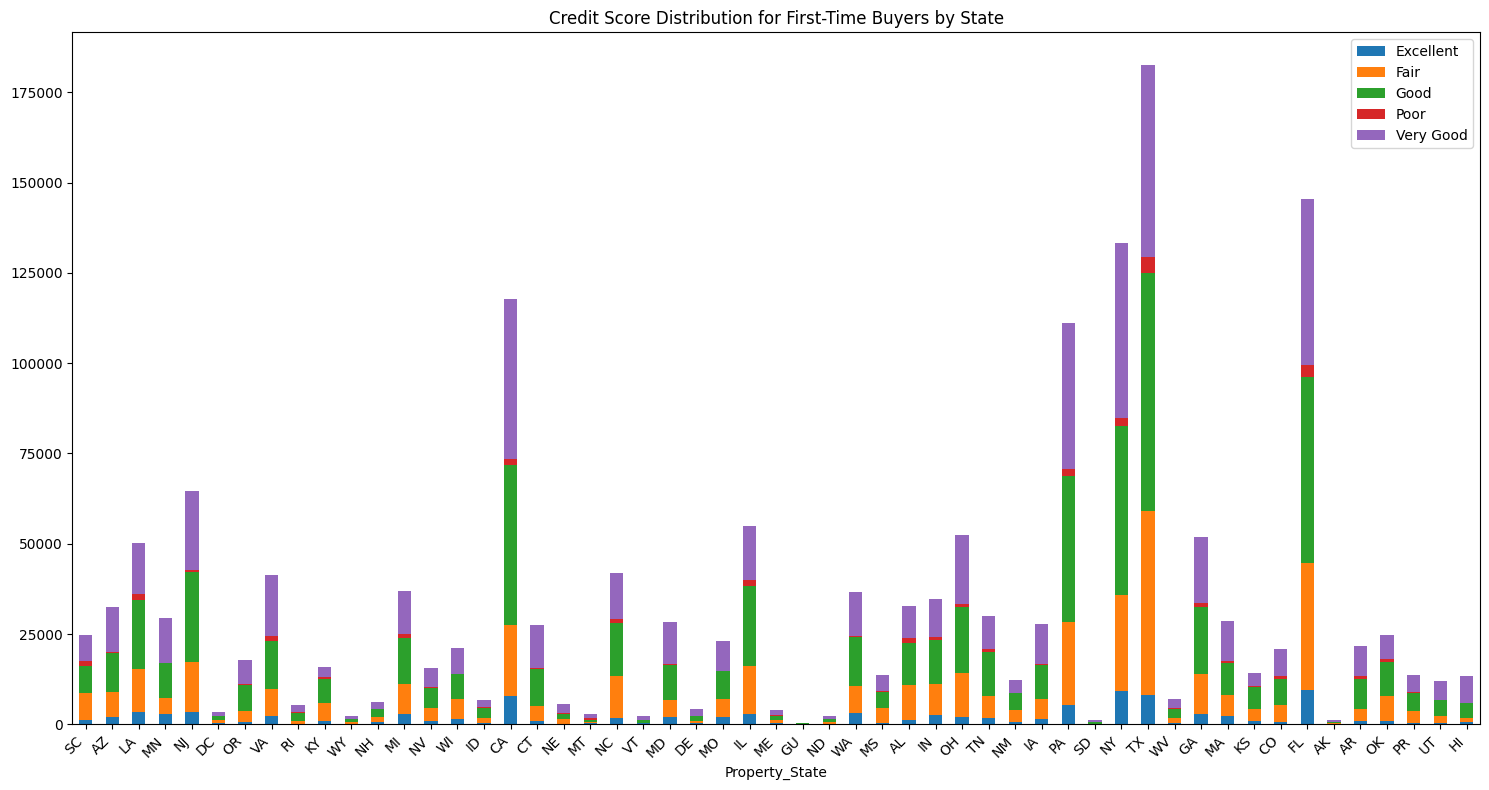

In [ ]:
import matplotlib.pyplot as plt

# Continue with the credit score bins and filtering
credit_bins = F.when(df['Borrower_Credit_Score_at_Origination'] < 580, 'Poor') \
    .when(df['Borrower_Credit_Score_at_Origination'] < 670, 'Fair') \
    .when(df['Borrower_Credit_Score_at_Origination'] < 740, 'Good') \
    .when(df['Borrower_Credit_Score_at_Origination'] < 800, 'Very Good') \
    .otherwise('Excellent')

state_credit_dist = df.filter(df['First_Time_Home_Buyer_Indicator'] == 'Y') \
    .withColumn('credit_category', credit_bins) \
    .groupBy('Property_State', 'credit_category').count()

# Pivot for stacked bar chart
state_credit_pivot = state_credit_dist.groupBy('Property_State').pivot('credit_category').sum('count')

# Convert to pandas for plotting
state_credit_pivot_pd = state_credit_pivot.toPandas().set_index('Property_State')

# Plotting the stacked bar chart with increased width
fig, ax = plt.subplots(figsize=(15, 8))  # Adjust the figsize to make it wider
state_credit_pivot_pd.plot(kind='bar', stacked=True, ax=ax, title='Credit Score Distribution for First-Time Buyers by State')

# Adjust the x-axis labels to fit
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()


## Q4. Analyze correlations between the FICO Score, LTV Ratio, and Interest Rate with the loan status.


In [ ]:
# Use Spark's built-in correlation function
from pyspark.sql.functions import corr

# Calculate correlations individually
fico_ltv_corr = df.corr('Borrower_Credit_Score_at_Origination', 'Original_Loan_to_Value_Ratio(LTV)')
fico_interest_corr = df.corr('Borrower_Credit_Score_at_Origination', 'Original_Interest_Rate')

print(f"FICO vs LTV correlation: {fico_ltv_corr}")
print(f"FICO vs Interest Rate correlation: {fico_interest_corr}")
# print(f"FICO vs Delinquency Status correlation: {fico_delinquency_corr}")

FICO vs LTV correlation: -0.18337844387232663
FICO vs Interest Rate correlation: -0.171188125741866


## Q5. Distribution of FICO Scores, LTV Ratios, and Interest Rates across different loan statuses (performing, delinquent, defaulted).


In [ ]:
df.show(2)

+-----------------+------------+------------------------+-------+--------------+--------------+---------------+----------------------+---------------------+-------------------+---------------+-----------+------------------+----------------+------------------+--------+----------------------------------+-------------------------------------+-------------+---------------------------------+-------------------------------------------+-------------------+-------------------+------------------------------------+---------------------------------------+-------------------------------+------------+-------------+---------------+----------------+--------------+-----+--------------+-----------------------------+-----------------+----------------------------+----------------------------+---------------------+----------------------+-------------------------------+--------------------+-----------------+-------------------------------+-----------------+---------------------------+----------------------

In [ ]:
from pyspark.sql.functions import col, when, count, avg, round

# Step 3: Define loan statuses
loan_status_df = df.withColumn(
    "Loan_Status",
    when(col("Current_Loan_Delinquency_Status") == 0, "Performing")
    .when((col("Current_Loan_Delinquency_Status") > 0) & (col("Current_Loan_Delinquency_Status") < 90), "Delinquent")
    .when(col("Current_Loan_Delinquency_Status") >= 90, "Defaulted")
    .otherwise("Unknown")
)

# Step 4: Define LTV ratio and FICO categories
loan_status_df = loan_status_df.withColumn(
    "LTV_Ratio", (col("Current_UPB") / col("Original_Actual_UPB")) * 100
)

# Define FICO categories based on 'Original_Interest_Rate' for illustration
loan_status_df = loan_status_df.withColumn(
    "FICO_Category",
    when(col("Original_Interest_Rate") >= 7.0, "Poor")
    .when((col("Original_Interest_Rate") >= 6.0) & (col("Original_Interest_Rate") < 7.0), "Fair")
    .when((col("Original_Interest_Rate") >= 5.0) & (col("Original_Interest_Rate") < 6.0), "Good")
    .when((col("Original_Interest_Rate") >= 4.0) & (col("Original_Interest_Rate") < 5.0), "Very Good")
    .otherwise("Excellent")
)

# Step 5: Group by Loan_Status and analyze FICO, LTV, and Interest Rates
distribution_df = loan_status_df.groupBy("Loan_Status").agg(
    count("*").alias("Total_Loans"),
    avg("LTV_Ratio").alias("Avg_LTV_Ratio"),
    avg("Original_Interest_Rate").alias("Avg_Interest_Rate"),
    avg("Borrower_Credit_Score_at_Origination").alias("Avg_Borrower_Credit_Score"),
    avg("Co-Borrower_Credit_Score_at_Origination").alias("Avg_Co-Borrower_Credit_Score")
)

# Step 6: Show the results
distribution_df.show(truncate=False)

# For FICO score distribution by Loan Status
fico_distribution_df = loan_status_df.groupBy("Loan_Status", "FICO_Category").count().orderBy("Loan_Status", "FICO_Category")

fico_distribution_df.show(truncate=False)


+-----------+-----------+---------------------+------------------+-------------------------+----------------------------+
|Loan_Status|Total_Loans|Avg_LTV_Ratio        |Avg_Interest_Rate |Avg_Borrower_Credit_Score|Avg_Co-Borrower_Credit_Score|
+-----------+-----------+---------------------+------------------+-------------------------+----------------------------+
|Defaulted  |1129       |82.0881345993724     |6.974625332152348 |673.6586936522539        |662.2114285714285           |
|Unknown    |955640     |0.0016928922517437212|6.642036650830843 |723.1551400505275        |730.6854314085466           |
|Delinquent |1361568    |82.10096550093634    |6.8669695835977205|660.457955012023         |664.5396260463181           |
|Performing |40220214   |70.91412027658666    |6.554638928102353 |723.6565332678842        |730.3308960488578           |
+-----------+-----------+---------------------+------------------+-------------------------+----------------------------+

+-----------+----------

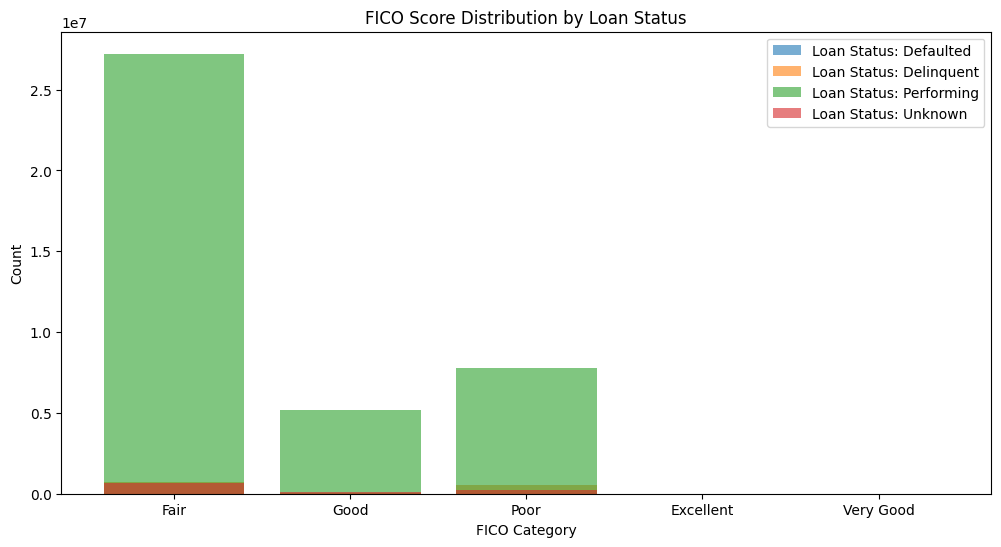

In [ ]:
import matplotlib.pyplot as plt

# Convert PySpark DataFrames to Pandas DataFrames
distribution_pd = distribution_df.toPandas()
fico_distribution_pd = fico_distribution_df.toPandas()
# Plot FICO Score Distribution
plt.figure(figsize=(12, 6))
for status in fico_distribution_pd["Loan_Status"].unique():
    subset = fico_distribution_pd[fico_distribution_pd["Loan_Status"] == status]
    plt.bar(subset["FICO_Category"], subset["count"], label=f'Loan Status: {status}', alpha=0.6)

plt.xlabel('FICO Category')
plt.ylabel('Count')
plt.title('FICO Score Distribution by Loan Status')
plt.legend()
plt.show()


## Q6. Compare default rates for loans originated in different quarters to assess if default risk has changed over time.

In [ ]:
loan_df = df

In [ ]:
df.show(2)

+-----------------+------------+------------------------+-------+--------------+--------------+---------------+----------------------+---------------------+-------------------+---------------+-----------+------------------+----------------+------------------+--------+----------------------------------+-------------------------------------+-------------+---------------------------------+-------------------------------------------+-------------------+-------------------+------------------------------------+---------------------------------------+-------------------------------+------------+-------------+---------------+----------------+--------------+-----+--------------+-----------------------------+-----------------+----------------------------+----------------------------+---------------------+----------------------+-------------------------------+--------------------+-----------------+-------------------------------+-----------------+---------------------------+----------------------

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, year, month, expr

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Loan Default Analysis") \
    .getOrCreate()



# Display schema and sample data to understand your columns
df.printSchema()
df.show(5)

# Define and create the Default_Status column
# Assuming Current_Loan_Delinquency_Status > 0 indicates default
df = df.withColumn("Default_Status", (col("Current_Loan_Delinquency_Status") > 0).cast("int"))

# Extract Year and Quarter from the Date column
# Assuming you have a column named 'Date' that you can use
df = df.withColumn("Year", year(col("Date")))
df = df.withColumn("Quarter", expr("ceil(month(Date) / 3.0)"))

# Aggregate by Year and Quarter to calculate default rates
default_rates = df.groupBy("Year", "Quarter") \
    .agg(mean("Default_Status").alias("default_rate"))

# Display the result
default_rates.show()

# Optionally, you can save the result to a file
# default_rates.write.csv("path_to_save_default_rates.csv")

# Stop Spark session
spark.stop()


root
 |-- Reference Pool ID: string (nullable = true)
 |-- Loan_ID: long (nullable = true)
 |-- Monthly_Reporting_Period: integer (nullable = true)
 |-- Channel: string (nullable = true)
 |-- Servicer_Name: string (nullable = true)
 |-- Seller_Name: string (nullable = true)
 |-- Master_Servicer: string (nullable = true)
 |-- Original_Interest_Rate: double (nullable = true)
 |-- Current_Interest_Rate: double (nullable = true)
 |-- Original_Actual_UPB: double (nullable = true)
 |-- UPB_at_Issuance: string (nullable = true)
 |-- Current_UPB: double (nullable = true)
 |-- Original_Loan_Term: integer (nullable = true)
 |-- Origination_Date: integer (nullable = true)
 |-- First_Payment_Date: integer (nullable = true)
 |-- Loan_Age: integer (nullable = true)
 |-- Remaining_Months_to_Legal_Maturity: integer (nullable = true)
 |-- Adjusted_Remaining_Months_to_Maturity: integer (nullable = true)
 |-- Maturity_Date: integer (nullable = true)
 |-- Original_Loan_to_Value_Ratio(LTV): integer (nullab

## Q7. The percentage of the loan amount recovered after default, through foreclosure or other means.

In [ ]:
df.show(2)

+-----------------+------------+------------------------+-------+--------------+--------------+---------------+----------------------+---------------------+-------------------+---------------+-----------+------------------+----------------+------------------+--------+----------------------------------+-------------------------------------+-------------+---------------------------------+-------------------------------------------+-------------------+-------------------+------------------------------------+---------------------------------------+-------------------------------+------------+-------------+---------------+----------------+--------------+-----+--------------+-----------------------------+-----------------+----------------------------+----------------------------+---------------------+----------------------+-------------------------------+--------------------+-----------------+-------------------------------+-----------------+---------------------------+----------------------

In [ ]:
from pyspark.sql import functions as F

# Corrected column names based on the error message suggestions
df = df.withColumn('recovery_rate', (F.col('Net_sales_proceeds') / F.col('UPB_at_the_Time_of_Removal')) * 100)

# Compute the average recovery rate
average_recovery_rate = df.agg(F.avg('recovery_rate').alias('avg_recovery_rate'))
average_recovery_rate.show()


+-----------------+
|avg_recovery_rate|
+-----------------+
|73.92110908258766|
+-----------------+



## Q8. Plot average, median, and variance of property price changes over the entire duration,bucketed by month.

In [ ]:
df.show(2)

+-----------------+------------+------------------------+-------+-------------+------------+---------------+----------------------+---------------------+-------------------+---------------+-----------+------------------+----------------+------------------+--------+----------------------------------+-------------------------------------+-------------+---------------------------------+-------------------------------------------+-------------------+-------------------+------------------------------------+---------------------------------------+-------------------------------+------------+-------------+---------------+----------------+--------------+-----+--------------+-----------------------------+-----------------+----------------------------+----------------------------+---------------------+----------------------+-------------------------------+--------------------+-----------------+-------------------------------+-----------------+---------------------------+-------------------------

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Assuming 'Original_Actual_UPB' or 'UPB_at_Issuance' as property price
price_stats = df.groupBy('Monthly_Reporting_Period').agg(
    F.avg('Original_Actual_UPB').alias('avg_price'),
    F.expr('percentile(Original_Actual_UPB, 0.5)').alias('median_price'),
    F.variance('Original_Actual_UPB').alias('price_variance')
)

# Display the result
price_stats.show()

from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Define a window partitioned by Loan_ID and ordered by Monthly_Reporting_Period
window_spec = Window.partitionBy('Loan_ID').orderBy('Monthly_Reporting_Period')

# Calculate property price change by subtracting the current month from the previous month
df = df.withColumn('property_price_change',
                   F.col('Current_UPB') - F.lag('Current_UPB').over(window_spec))

# Show the property price change
df.select('Loan_ID', 'Monthly_Reporting_Period', 'Current_UPB', 'property_price_change').show(5)


+------------------------+------------------+------------+--------------------+
|Monthly_Reporting_Period|         avg_price|median_price|      price_variance|
+------------------------+------------------+------------+--------------------+
|                   12003|143248.84968163786|    131000.0| 4.683261050905848E9|
|                   12006|142109.95482801064|    127000.0| 5.034427024388633E9|
|                   12007|142566.64586758462|    128000.0| 5.067186234825533E9|
|                   12008| 143045.2975035668|    128000.0| 5.097418764598548E9|
|                   12012| 133542.0549874947|    119000.0| 4.626828019017386E9|
|                   12013|128830.24558797933|    114000.0| 4.375793495389357E9|
|                   12014| 125310.7348768316|    110000.0|4.1822823503281965E9|
|                   12015|124466.61733905374|    110000.0|4.1321781949615245E9|
|                   12022|121399.38656680685|    106000.0|3.9491185730914626E9|
|                   12023|122038.9990946

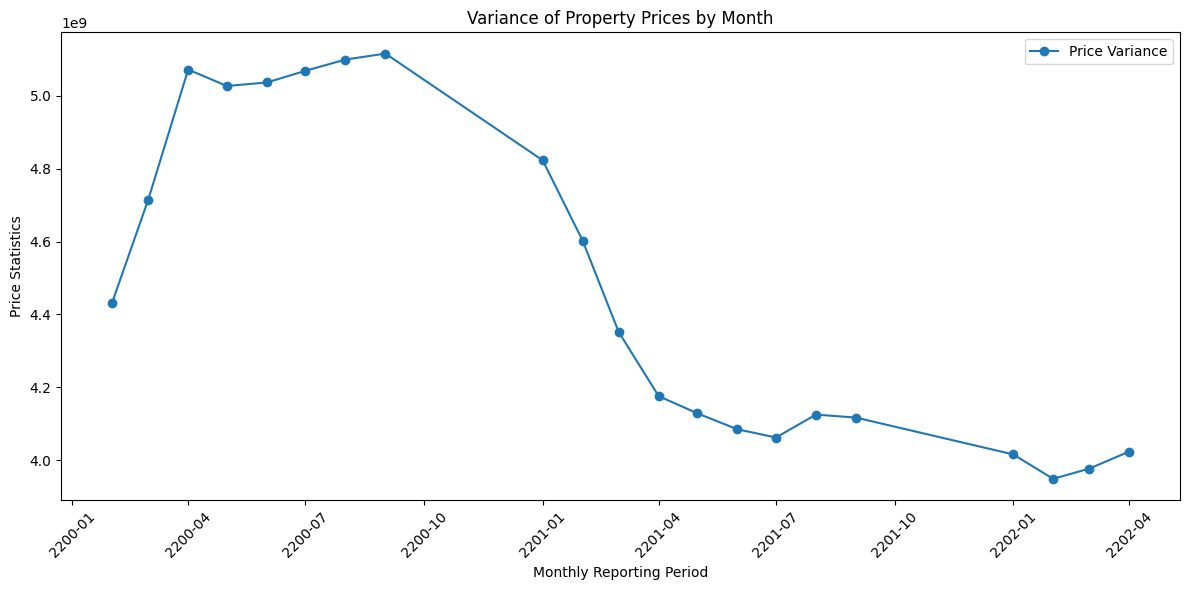

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt

# Define a window partitioned by Loan_ID and ordered by Monthly_Reporting_Period
window_spec = Window.partitionBy('Loan_ID').orderBy('Monthly_Reporting_Period')

# Calculate property price change by subtracting the current month from the previous month
df = df.withColumn('property_price_change',
                   F.col('Current_UPB') - F.lag('Current_UPB').over(window_spec))

# Assuming 'Original_Actual_UPB' or 'UPB_at_Issuance' as property price
price_stats = df.groupBy('Monthly_Reporting_Period').agg(
    F.avg('Original_Actual_UPB').alias('avg_price'),
    F.expr('percentile(Original_Actual_UPB, 0.5)').alias('median_price'),
    F.variance('Original_Actual_UPB').alias('price_variance')
)


# Convert your Spark DataFrame to a Pandas DataFrame for plotting
price_stats_pandas = price_stats.toPandas()

# Convert Monthly_Reporting_Period to datetime, handling potential errors
price_stats_pandas['Monthly_Reporting_Period'] = pd.to_datetime(price_stats_pandas['Monthly_Reporting_Period'], format='%Y%m', errors='coerce')

# Drop rows with invalid dates
price_stats_pandas = price_stats_pandas.dropna(subset=['Monthly_Reporting_Period'])

# Sort the DataFrame by date to ensure proper plotting
price_stats_pandas = price_stats_pandas.sort_values('Monthly_Reporting_Period')

# Plotting
plt.figure(figsize=(12, 6))

# Plot variance of property prices
plt.plot(price_stats_pandas['Monthly_Reporting_Period'], price_stats_pandas['price_variance'], label='Price Variance', marker='o')

# Set the x-axis label, y-axis label, and title
plt.xlabel('Monthly Reporting Period')
plt.ylabel('Price Statistics')
plt.title('Variance of Property Prices by Month')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()